In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline
warnings.filterwarnings('ignore') 

In [2]:
SEGMENTATION_PATH = os.path.join('data', 'segmentation.csv')

The dataset consists of information about the purchasing behavior of 2,000 individuals from a given area when entering a physical ‘FMCG’ store. All data has been collected through the loyalty cards they use at checkout. The data has been preprocessed and there are no missing values. In addition, the volume of the dataset has been restricted and anonymised to protect the privacy of the customers. 

### Legend

- **ID :** Shows a unique identificator of a customer.
- **Sex :** Biological sex (gender) of a customer. In this dataset there are only 2 different options 
    - 0 : male, 
    - 1 : female
- **Age :** The age of the customer in years, calculated as current year minus the year of birth of the customer at the time of creation of the dataset
- **Education :** Level of education of the customer 
    - 0 : Other/Unknown, 
    - 1 : High school, 
    - 2 : University, 
    - 3 : Graduate school
- **Income :** Self-reported annual income in US dollars of the customer. 
- **Occupation :** Category of occupation of the customer 
    - 0 : Unemployeed / Unskilled, 
    - 1 : Skilled employee / Official, 
    - 2 : Management / Self-employed / Highly qualified employee)
- **Settlement size :** The size of the city that the customer lives in 
    - 0 : Small city, 
    - 1 : Mid-sized city, 
    - 2 : Big city


---
## Data Explorataion


### Get the data

In [3]:
def load_csv_data(filepath) :
    return pd.read_csv(filepath)

In [4]:
segmt = load_csv_data(SEGMENTATION_PATH)
segmt.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


---
### Explore the data

In [5]:
segmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [6]:
segmt.describe()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,1.000010e+08,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,5.774946e+02,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,1.000000e+08,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,1.000005e+08,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,1.000010e+08,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000015e+08,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000020e+08,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


In [7]:
segmt.ID = segmt.ID.astype('str')

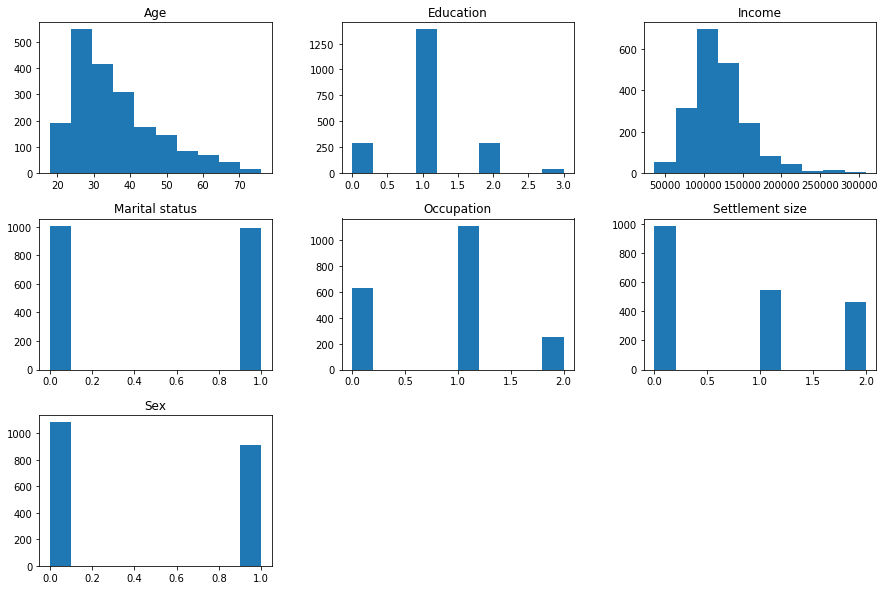

In [8]:
segmt.hist(grid=False, figsize=(15,10))
plt.show()

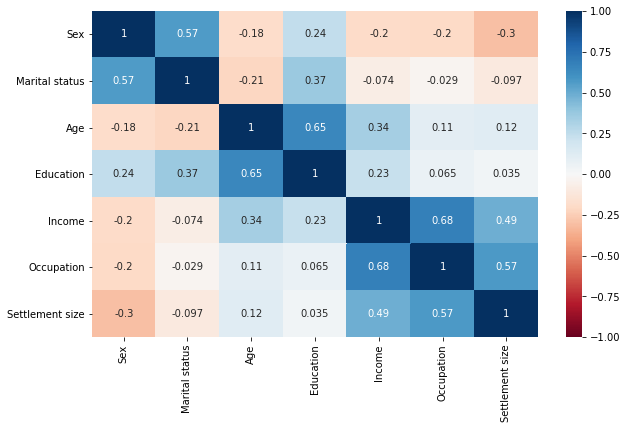

In [9]:
segmt_correlation = segmt.corr()

plt.figure(figsize = (10, 6))
sns.heatmap(data = segmt_correlation, annot=True, cmap="RdBu",
            vmax = 1, vmin = -1)
plt.show()

- Income - Occupation & Education - Age have moderate positive correlation. <br>
- Two quantitative variables Age - income also have moderate positive correlation.

In [10]:
occupation_cat = {
    0 : 'Unemployeed', 
    1 : 'Employeed', 
    2 : 'Management'
}
education_cat = {
    0 : 'Unknown', 
    1 : 'High school', 
    2 : 'Undergraduate', 
    3 : 'Graduate'
}

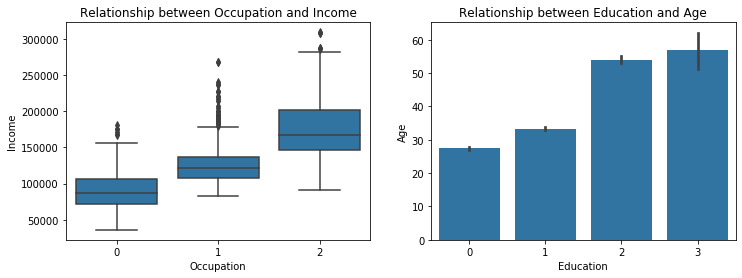

In [11]:
plt.figure(figsize=(12,4))
base_color = sns.color_palette()[0]

plt.subplot(1,2,1)

plt.title('Relationship between Occupation and Income')
plt.xlabel('Occupation')
plt.ylabel('Income')

fig1 = sns.boxplot(data=segmt, x='Occupation', y='Income', color=base_color)

plt.subplot(1,2,2)
plt.title('Relationship between Education and Age')
plt.xlabel('Age')
plt.ylabel('Income')

fig2 = sns.barplot(data=segmt, y='Age', x='Education', estimator=np.mean, ci=95, color=base_color)

plt.show()

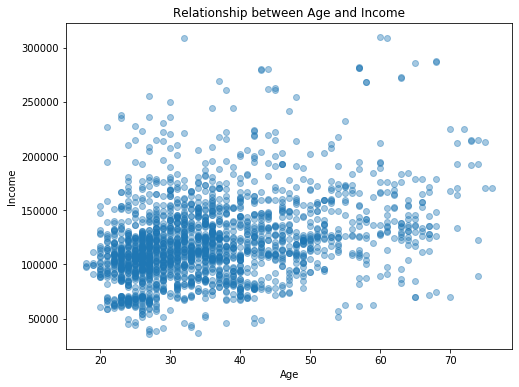

In [12]:
plt.figure(figsize=(8,6))
plt.title('Relationship between Age and Income')
plt.xlabel('Age')
plt.ylabel('Income')

plt.scatter(data=segmt, x='Age', y='Income', alpha=0.4)
plt.show()

---
### Preprocessing

In [13]:
scaler = StandardScaler()
segmt_std = scaler.fit_transform(segmt.iloc[:, 1:]) # remove id 

In [14]:
segmt_std.shape

(2000, 7)

---
## Clustering Algorithm

### `1` Hierarchical clustering

Agglomerative (bottom-up) : based on the distances between each data point, building clusters https://en.wikipedia.org/wiki/Hierarchical_clustering 

In [15]:
hier_cluster = linkage(y=segmt_std, method='ward')

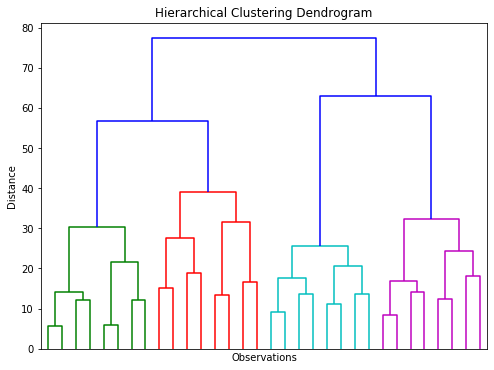

In [16]:
plt.figure(figsize = (8, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')

dendrogram(hier_cluster, no_labels=True,
           truncate_mode='level', p=4)
plt.show()

Hierarchical clustering is quite slow, but is a good way to identify the number of clusters.

---
### `2` K-Means clustering
Based on k-clusters (k <= n observation) using centroids - calculating wcss (within cluster sum of squares) 
- Wikipedia : https://en.wikipedia.org/wiki/K-means_clustering
- Scikit-Learn : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

When not sure about how many clusters (k) : 

One of the ways is to iterate an array of k to calculate wcss and find the lowest point using the elbow methods 

In [17]:
segmt_std

array([[-0.91739884, -0.99302433,  2.65361447, ...,  0.09752361,
         0.29682303,  1.552326  ],
       [ 1.09003844,  1.00702467, -1.18713209, ...,  0.78265438,
         0.29682303,  1.552326  ],
       [-0.91739884, -0.99302433,  1.11731585, ..., -0.83320224,
        -1.26952539, -0.90972951],
       ...,
       [-0.91739884, -0.99302433, -0.41898277, ..., -0.90695688,
        -1.26952539, -0.90972951],
       [ 1.09003844,  1.00702467, -1.01643224, ..., -0.60332923,
        -1.26952539, -0.90972951],
       [-0.91739884, -0.99302433, -0.93108232, ..., -1.3789866 ,
        -1.26952539, -0.90972951]])

#### Find the number of clusters k

In [18]:
wcss = []

for i in range(1, 11) : 
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state=42)
    kmeans.fit(segmt_std)
    wcss.append(kmeans.inertia_)

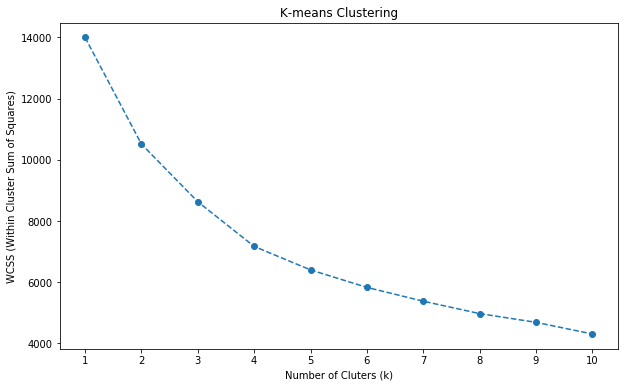

In [19]:
plt.figure(figsize=(10,6))
plt.title('K-means Clustering')
plt.xlabel('Number of Cluters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.xticks(np.arange(1,11))

plt.plot(np.arange(1,11), wcss, marker='o', ls='--')
plt.show()

K = 4 is the point where the graph ends steep declining and smoothens out afterwards. When in doubt, hierarchical clustering may support. 

Based on the result (number of cluster = 4), K-means is fitted again.

#### Fitting the data

In [20]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(segmt_std)

KMeans(n_clusters=4, random_state=42)

#### Results

In [21]:
kmeans.cluster_centers_

array([[ 0.09013622,  0.39104   ,  1.68945241,  1.81991857,  0.98122555,
         0.49931674,  0.45703895],
       [-0.20914716, -0.95406234, -0.02825748, -0.48571087, -0.60616779,
        -0.75418998, -0.85643827],
       [-0.8575279 , -0.6456474 , -0.02337839, -0.5080912 ,  0.53186888,
         0.72275988,  0.9648882 ],
       [ 0.79675328,  1.00135077, -0.59283028,  0.05017279, -0.39883413,
        -0.27639384, -0.38938019]])

In [22]:
segmt_kmeans = segmt.copy()
segmt_kmeans['Segment'] = kmeans.labels_

In [23]:
segmt_analysis = segmt_kmeans.groupby('Segment').mean()

In [24]:
segmt_analysis.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695


#### Labeling the segments 

In [25]:
segmt_analysis = segmt_analysis.rename(index = {
    0 : 'Well-off',
    1 : 'Lower-opportunity',
    2 : 'Career-focused',
    3 : 'Standard'
})

In [26]:
segmt_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment,,,,,,,
Well-off,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
Lower-opportunity,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
Career-focused,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807
Standard,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695


In [27]:
segmt_kmeans['Segment'] = segmt_kmeans['Segment'].map({
    0 : 'Well-off',
    1 : 'Lower-opportunity',
    2 : 'Career-focused',
    3 : 'Standard'
})

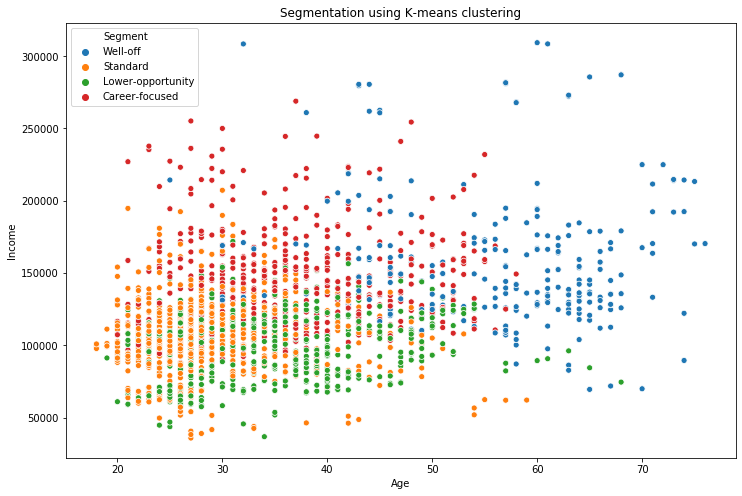

In [28]:
plt.figure(figsize=(12,8))
plt.title('Segmentation using K-means clustering')
plt.xlabel('Age')
plt.ylabel('Income')

# plt.scatter(data=segmt_kmeans, x='Age', y='Income', alpha=0.4, 
#             c=segmt_kmeans['Segment'], cmap='jet')

sns.scatterplot(data=segmt_kmeans, x='Age', y='Income',
                hue=segmt_kmeans['Segment'], palette=sns.color_palette(n_colors=4))

plt.show()

The segmentation is clearly represented for 'Well-off' cluster. However, it does not give a perfect distinction to the other clusters. Here PCA (Principle Component Analaysis) comes in to join the K-means clustering algorithm and improve the `visualization`.

---
## Principal Component Analysis (PCA)

PCA assumes the dataset is centered around its origin. Preprocessing to normalize the data is therefore crucial before applying the algorithm. 

In [29]:
segmt_std.shape

(2000, 7)

In [30]:
pca = PCA() # n_components

In [31]:
pca.fit(segmt_std)

PCA()

In [32]:
pca.components_.shape, pca.explained_variance_.sum()

((7, 7), 7.00350175087544)

### Choosing the right number of clusters

In [33]:
pca.explained_variance_ratio_ # when 95% variance to be retained as a parameter

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

In [34]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 # max n_components where at least 95% variance is retained
d

6

or visualize : elbow method 

In [35]:
variance_retained = []

for i in range(1, segmt_std.shape[1]+1) :
    pca = PCA(n_components=i)
    pca.fit(segmt_std)
    variance_retained.append(pca.explained_variance_ratio_.sum() * 100)

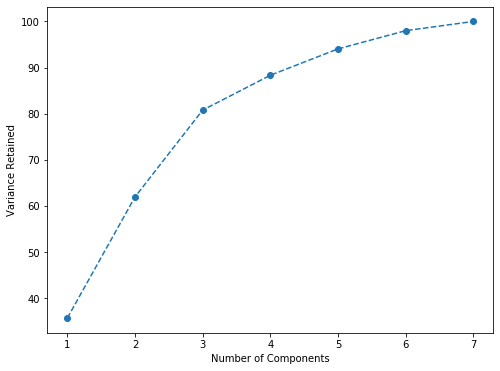

In [36]:
plt.figure(figsize=(8,6))
plt.xlabel('Number of Components')
plt.ylabel('Variance Retained')
plt.xticks(np.arange(segmt_std.shape[1]), np.arange(segmt_std.shape[1])+1)

plt.plot(variance_retained, ls='--', marker='o');
plt.show() # at least 3 components retaining around 80%

As it is to improve the visualization of the dataset, we will go with 4 components with 85% variance retained.

### Applying the pca

In [37]:
pca = PCA(n_components=3)
pca.fit(segmt_std)

PCA(n_components=3)

### Result of the pca

In [38]:
pca.components_.shape # k x n matrix

(3, 7)

In [39]:
df_pca_components = pd.DataFrame(data=pca.components_,
                                 columns=segmt.columns.values[1:],
                                 index=['Component ' + str(i) 
                                        for i in range(1, pca.components_.shape[0]+1)])

In [40]:
df_pca_components

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


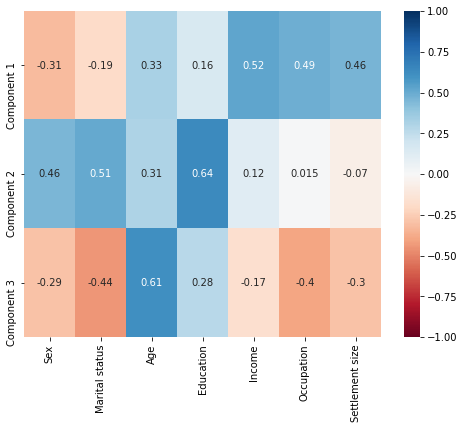

In [41]:
plt.figure(figsize=(8,6))
sns.heatmap(df_pca_components,
            vmin=-1, vmax=1, annot=True, 
            cmap='RdBu')
plt.show()

### Interpretation 
- Component 1 : Career-focused
- Component 2 : Life_style
- Component 3 : Experience

In [42]:
pca.transform(segmt_std)

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

In [43]:
pca_scores = pca.transform(segmt_std)

---
## KMeans Clustering with Principal Component Analysis (PCA) 

In [51]:
wcss = []

for i in range(1, 11) : 
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(pca_scores)
    wcss.append(kmeans.inertia_)

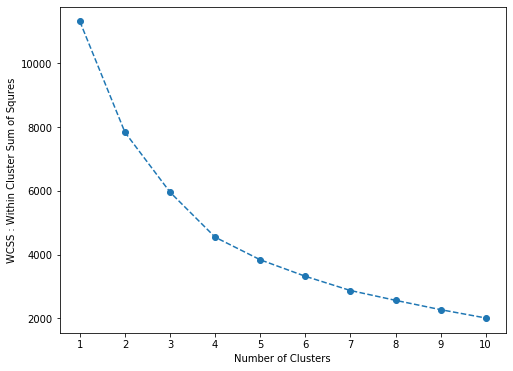

In [52]:
plt.figure(figsize=(8,6))
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS : Within Cluster Sum of Squres')
plt.xticks(np.arange(0,10), np.arange(0,10)+1)

plt.plot(wcss, ls='--', marker='o')
plt.show() # here we go with 4 clusteres again

In [99]:
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_pca.fit(pca_scores)

KMeans(n_clusters=4, random_state=42)

In [100]:
kmeans_pca.labels_

array([3, 2, 0, ..., 0, 2, 0], dtype=int32)

In [101]:
segmt_kmeans_pca = segmt.copy().iloc[:, 1:].reset_index(drop=True)
df_components = pd.DataFrame(pca_scores, columns = ['Component '+ str(i) 
                                                    for i in range(1, 4)])

In [102]:
segmt_kmeans_pca = pd.concat([segmt_kmeans_pca, df_components], axis=1)
segmt_kmeans_pca['Segment'] = kmeans_pca.labels_

In [103]:
segment_analysis_pca = segmt_kmeans_pca.groupby('Segment').mean()
segment_analysis_pca

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment,,,,,,,,,,
0,0.307190,0.098039,35.383442,0.766885,93566.102397,0.248366,0.039216,-1.048838,-0.892116,1.010446
1,0.027350,0.167521,35.700855,0.731624,141489.721368,1.266667,1.475214,1.367167,-1.050209,-0.247981
2,0.900433,0.965368,28.913420,1.062049,107551.946609,0.676768,0.440115,-1.106918,0.706367,-0.778269
3,0.505703,0.688213,55.722433,2.129278,158391.676806,1.129278,1.110266,1.706153,2.031716,0.838839


In [104]:
count_by_segmt = segmt_kmeans_pca[['Segment','Sex']].groupby('Segment').count()
total_count = count_by_segmt.sum()

In [107]:
segment_analysis_pca['N_Obs'] = count_by_segmt
segment_analysis_pca['Perc_Obs'] = count_by_segmt / total_count

#### Note the index is different from the earlier kmeans

In [110]:
segment_analysis_pca.rename(index={
    0 : 'Fewer Opportuntiy',
    1 : 'Career Focused',
    2 : 'Standard',
    3 : 'Well off'
}, inplace=True)

In [111]:
segment_analysis_pca

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,N_Obs,Perc_Obs
Segment,,,,,,,,,,,,
Fewer Opportuntiy,0.307190,0.098039,35.383442,0.766885,93566.102397,0.248366,0.039216,-1.048838,-0.892116,1.010446,459,0.2295
Career Focused,0.027350,0.167521,35.700855,0.731624,141489.721368,1.266667,1.475214,1.367167,-1.050209,-0.247981,585,0.2925
Standard,0.900433,0.965368,28.913420,1.062049,107551.946609,0.676768,0.440115,-1.106918,0.706367,-0.778269,693,0.3465
Well off,0.505703,0.688213,55.722433,2.129278,158391.676806,1.129278,1.110266,1.706153,2.031716,0.838839,263,0.1315


In [114]:
segmt_kmeans_pca['Legend'] = segmt_kmeans_pca['Segment'].map({
    0 : 'Fewer Opportuntiy',
    1 : 'Career Focused',
    2 : 'Standard',
    3 : 'Well off'
})

- Component 1 : Career-focused
- Component 2 : Life_style
- Component 3 : Experience

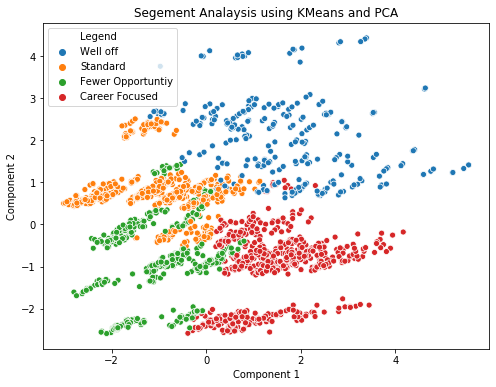

In [128]:
plt.figure(figsize=(8, 6))
plt.title('Segement Analaysis using KMeans and PCA')

sns.scatterplot(x=segmt_kmeans_pca['Component 1'], 
                y=segmt_kmeans_pca['Component 2'], 
                hue=segmt_kmeans_pca['Legend'])
plt.show()

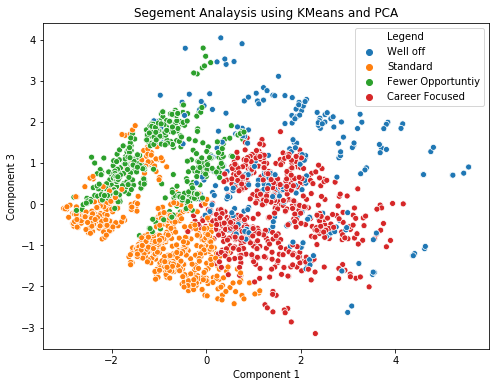

In [130]:
plt.figure(figsize=(8, 6))
plt.title('Segement Analaysis using KMeans and PCA')

sns.scatterplot(x=segmt_kmeans_pca['Component 1'], 
                y=segmt_kmeans_pca['Component 3'], 
                hue=segmt_kmeans_pca['Legend'])
plt.show()

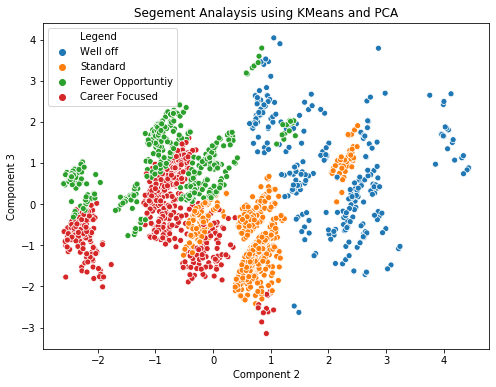

In [131]:
plt.figure(figsize=(8, 6))
plt.title('Segement Analaysis using KMeans and PCA')

sns.scatterplot(x=segmt_kmeans_pca['Component 2'], 
                y=segmt_kmeans_pca['Component 3'], 
                hue=segmt_kmeans_pca['Legend'])
plt.show()

---
## Data Export 
Using python pickle library : python object to file

In [143]:
os.makedirs('obj_data')

In [149]:
pickle.dump(scaler, open('obj_data/scaler.pickle', 'wb'))
pickle.dump(pca, open('obj_data/pca.pickle', 'wb'))
pickle.dump(kmeans_pca, open('obj_data/kmeans_pca.pickle', 'wb'))